In [1]:
#============================================================================
#                           Importing Required Libraries
#============================================================================

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
from sklearn.metrics import confusion_matrix

In [2]:
#============================================================================
#              Importing Data (with text as strings and not factors)
#============================================================================
path = '/home/henri/Documents/Lighthouse lab/Databases/w5-d1-db/adult.csv'
adult_try_logistic = pd.read_csv(path)
type(adult_try_logistic)
adult_try_logistic.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

In [3]:
#============================================================================
#              Replacing "?" with NA and Encoding Dependent Variable
#                  1 = Preferred Event | 0 = Alternate Event
#============================================================================

stack = adult_try_logistic.stack()
stack[stack == "?"] = None
adult_try_logistic = stack.unstack()

adult_try_logistic.income[adult_try_logistic.income == ">50K"] = 1
adult_try_logistic.income[adult_try_logistic.income == "<=50K"] = 0

In [4]:
#============================================================================
#                       Converting text to lower case
#============================================================================

adult_try_logistic.workclass = adult_try_logistic.workclass.str.lower()
adult_try_logistic.occupation = adult_try_logistic.occupation.str.lower()
adult_try_logistic.education = adult_try_logistic.education.str.lower()
adult_try_logistic.race = adult_try_logistic.race.str.lower()
adult_try_logistic.gender = adult_try_logistic.gender.str.lower()
adult_try_logistic['native-country'] = adult_try_logistic['native-country'].str.lower()
adult_try_logistic['marital-status'] = adult_try_logistic['marital-status'].str.lower()
adult_try_logistic.relationship = adult_try_logistic.relationship.str.lower()

In [5]:
#=============================================================================
#                      Checking for % of Missing Values
# Decide whether to impute or not. If yes, with or without category wise median /           mean / mode
#                        If not, encode Missing Values
#=============================================================================

pd.isna(adult_try_logistic).mean() # gives col wise %age
type(adult_try_logistic)
adult_try_logistic.dtypes

age                object
workclass          object
fnlwgt             object
education          object
educational-num    object
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain       object
capital-loss       object
hours-per-week     object
native-country     object
income             object
dtype: object

In [6]:
#=============================================================================
#                          Check for Imbalanced Data
#=============================================================================
adult_try_logistic.income.value_counts()

0    37155
1    11687
Name: income, dtype: int64

In [7]:
#=============================================================================
#                          Missing Value Replacement
#=============================================================================

adult_try_logistic.workclass[pd.isna(adult_try_logistic.workclass)]= "missing_workclass"
adult_try_logistic.occupation[pd.isna(adult_try_logistic.occupation)]= "missing_occupation"
adult_try_logistic['native-country'][pd.isna(adult_try_logistic['native-country'])]= "missing_country"

In [8]:
#=============================================================================
#                         Check Information Value (IV)
#=============================================================================
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF = pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = d['Events'] / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = d['Non-Events'] / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars],
                            "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF

IV_Table = iv_woe(data = adult_try_logistic, target = 'income', bins=10, show_woe = True)

# Taken from https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

/home/henri/miniconda2/envs/lighthouse-lab-course/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/henri/miniconda2/envs/lighthouse-lab-course/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Information value of age is inf
    Cutoff     N  Events  % of Events  Non-Events  % of Non-Events       WoE  \
0       17   595       0     0.000000         595         0.016014      -inf   
1       18   862       0     0.000000         862         0.023200      -inf   
2       19  1053       3     0.000257        1050         0.028260 -4.701312   
3       20  1113       1     0.000086        1112         0.029929 -5.857294   
4       21  1096       6     0.000513        1090         0.029337 -4.045552   
..     ...   ...     ...          ...         ...              ...       ...   
69      86     1       0     0.000000           1         0.000027      -inf   
70      87     3       0     0.000000           3         0.000081      -inf   
71      88     6       1     0.000086           5         0.000135 -0.452817   
72      89     2       0     0.000000           2         0.000054      -inf   
73      90    55      13     0.001112          42         0.001130 -0.016099   

       

/home/henri/miniconda2/envs/lighthouse-lab-course/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/henri/miniconda2/envs/lighthouse-lab-course/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/henri/miniconda2/envs/lighthouse-lab-course/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Information value of fnlwgt is inf
        Cutoff  N  Events  % of Events  Non-Events  % of Non-Events       WoE  \
0        12285  1       0     0.000000           1         0.000027      -inf   
1        13492  1       0     0.000000           1         0.000027      -inf   
2        13769  3       1     0.000086           2         0.000054  0.463474   
3        13862  1       0     0.000000           1         0.000027      -inf   
4        14878  1       1     0.000086           0         0.000000       inf   
...        ... ..     ...          ...         ...              ...       ...   
28518  1268339  1       0     0.000000           1         0.000027      -inf   
28519  1366120  1       0     0.000000           1         0.000027      -inf   
28520  1455435  1       0     0.000000           1         0.000027      -inf   
28521  1484705  1       0     0.000000           1         0.000027      -inf   
28522  1490400  1       0     0.000000           1         0.000027      -

/home/henri/miniconda2/envs/lighthouse-lab-course/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/henri/miniconda2/envs/lighthouse-lab-course/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
#============================================================================
#                             Thumb Rule for IV
#============================================================================
#Information Value	Predictive Power
#< 0.02	useless for prediction
#0.02 to 0.1	Weak predictor
#0.1 to 0.3	Medium predictor
#0.3 to 0.5	Strong predictor
#>0.5	Suspicious or too good to be true

In [10]:
#=============================================================================

#=============================================================================
#                          Converting back to Factor Variables
#=============================================================================
adult_try_logistic.workclass = adult_try_logistic.workclass.astype('category')
adult_try_logistic.occupation = adult_try_logistic.occupation.astype('category')
adult_try_logistic['native-country'] = adult_try_logistic['native-country'].astype('category')
adult_try_logistic.race = adult_try_logistic.race.astype('category')
adult_try_logistic.gender = adult_try_logistic.gender.astype('category')
adult_try_logistic.relationship = adult_try_logistic.relationship.astype('category')
adult_try_logistic.income = adult_try_logistic.income.astype('category')
adult_try_logistic.education = adult_try_logistic.education.astype('category')
adult_try_logistic['marital-status'] = adult_try_logistic['marital-status'].astype('category')
adult_try_logistic.dtypes

age                  object
workclass          category
fnlwgt               object
education          category
educational-num      object
marital-status     category
occupation         category
relationship       category
race               category
gender             category
capital-gain         object
capital-loss         object
hours-per-week       object
native-country     category
income             category
dtype: object

In [11]:
#                      Choosing Relevant Independent Variables
#=============================================================================

adult_try_logistic = adult_try_logistic.drop(axis=1,columns=['fnlwgt','race','capital-loss','native-country'])

In [12]:
#============================================================================
#                        Reducing Levels in Factor Variables (<10)
#============================================================================

# DIY

In [13]:
#============================================================================
#                           Create Training Data (Bootstrapping)
#============================================================================
adult_try_logistic = adult_try_logistic.rename(columns={"hours-per-week":"hours_per_week"})
adult_try_logistic.age = adult_try_logistic.age.astype('int')
adult_try_logistic['educational-num'] = adult_try_logistic['educational-num'].astype('int')
adult_try_logistic['capital-gain'] = adult_try_logistic['capital-gain'].astype('int')
adult_try_logistic.hours_per_week = adult_try_logistic.hours_per_week.astype('int')


input_ones = adult_try_logistic[adult_try_logistic.income == 1]  # all 1's code (encoding) of whichever level is lower in frequency
input_zeroes = adult_try_logistic[adult_try_logistic.income == 0]  # all 0's
random.seed(100)
training_ones = input_ones.sample(frac=0.7)
training_zeroes = input_zeroes.sample(frac=0.7)
trainingData = pd.concat([training_ones,training_zeroes])

In [14]:
#===========================================================================
#                               Create Test Data
#===========================================================================
test_ones = input_ones.loc[~input_ones.index.isin(training_ones.index)]
test_zeroes = input_zeroes.loc[~input_zeroes.index.isin(training_zeroes.index)]
testData = pd.concat([test_ones,test_zeroes])  # row bind the 1's and 0's

In [15]:
#===========================================================================
#                      Modeling (Tuning based on p-values)
#                  Number of Fisher Iterations should be less
#===========================================================================
logitMod = smf.glm('income ~ age + C(workclass) + C(education) + C(occupation) + hours_per_week', data=trainingData, family=sm.families.Binomial()).fit()
logitMod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                      
======================================================================================
Dep. Variable:     ['income[0]', 'income[1]']   No. Observations:                34189
Model:                                    GLM   Df Residuals:                    34150
Model Family:                        Binomial   Df Model:                           38
Link Function:                          logit   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:                -14500.
Date:                        Mon, 12 Oct 2020   Deviance:                       29000.
Time:                                16:46:31   Pearson chi2:                 3.22e+04
No. Iterations:                            21                                         
Covariance Type:                    nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               5.9630      0.179     33.263      0.000       5.612       6.314
C(workclass)[T.local-gov]               0.5957      0.092      6.464      0.000       0.415       0.776
C(workclass)[T.missing_workclass]      -5.8572   5092.269     -0.001      0.999   -9986.521    9974.807
C(workclass)[T.never-worked]           12.5668   1.02e+04      0.001      0.999   -1.99e+04       2e+04
C(workclass)[T.private]                 0.4588      0.077      5.974      0.000       0.308       0.609
C(workclass)[T.self-emp-inc]           -0.0410      0.102     -0.403      0.687      -0.241       0.159
C(workclass)[T.self-emp-not-inc]        0.7390      0.091      8.101      0.000       0.560       0.918
C(workclass)[T.state-gov]               0.7217      0.102      7.064      0.000       0.522       0.922
C(workclass)[T.without-pay]             1.0268      1.085      0.946      0.344      -1.101       3.154
C(education)[T.11th]                   -0.0042      0.189     -0.022      0.982      -0.374       0.366
C(education)[T.12th]                   -0.4751      0.224     -2.119      0.034      -0.914      -0.036
C(education)[T.1st-4th]                 0.7130      0.445      1.601      0.109      -0.160       1.586
C(education)[T.5th-6th]                 0.2978      0.288      1.035      0.300      -0.266       0.861
C(education)[T.7th-8th]                 0.5299      0.214      2.476      0.013       0.111       0.949
C(education)[T.9th]                     0.2968      0.243      1.220      0.222      -0.180       0.773
C(education)[T.assoc-acdm]             -1.3780      0.153     -9.026      0.000      -1.677      -1.079
C(education)[T.assoc-voc]              -1.3946      0.148     -9.437      0.000      -1.684      -1.105
C(education)[T.bachelors]              -1.9552      0.138    -14.207      0.000      -2.225      -1.685
C(education)[T.doctorate]              -2.8898      0.182    -15.908      0.000      -3.246      -2.534
C(education)[T.hs-grad]                -0.8604      0.135     -6.377      0.000      -1.125      -0.596
C(education)[T.masters]                -2.2396      0.145    -15.491      0.000      -2.523      -1.956
C(education)[T.preschool]               1.0759      1.026      1.049      0.294      -0.935       3.087
C(education)[T.prof-school]            -2.9781      0.170    -17.503      0.000      -3.312      -2.645
C(education)[T.some-college]           -1.1436      0.137     -8.369      0.000      -1.411      -0.876
C(occupation)[T.armed-forces]          -0.6001      0.771     -0.779      0.436      -2.111       0.910
C(occupation)[T.craft-repair]          -0.8090      0.064    -12.616      0.000    

In [16]:
#===========================================================================
#                            Testing (Prediction)
#===========================================================================

predicted = logitMod.predict(testData[['age','workclass','education','occupation','hours_per_week']])

In [17]:
#===========================================================================
#                          Deciding Optimal Cut-off
# Cut-off is the point above which it is 1 (Preferred Event) and below it, is 0 (Alternate Event)
# Ideal cut off is 0.5 which means if the prediction is 0.4 or 40% it is an Alternate Event, but sometimes due to imbalance
# in your dataset, the cut-off is higher say 0.92 which means if your prediction is 0.88 it is still Alternate Event.
#===========================================================================

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(testData.income, predicted)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})

Area under the ROC curve : 0.178593


In [18]:
# Threshold
optCutOff = roc.ix[(roc.tf-0).abs().argsort()[:1]]

AttributeError: 'DataFrame' object has no attribute 'ix'

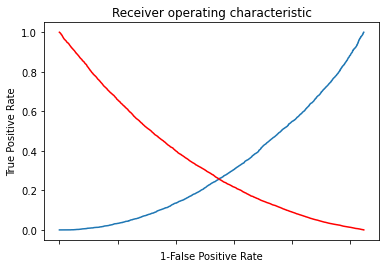

In [19]:
# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])
plt.show()

In [20]:
#============================================================================
#                        Checking Accuracy of the Model
#============================================================================

fitted_results = predicted
for k in fitted_results.index:
    print(k)
    if fitted_results[k] >= optCutOff['thresholds'].values:
        fitted_results[k]=1
    else:
        fitted_results[k]=0

misClasificError = np.mean(fitted_results != testData.income)
print('Accuracy',1-misClasificError)

3


NameError: name 'optCutOff' is not defined

In [21]:
#============================================================================
#                               Confusion Matrix
#============================================================================

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

results = confusion_matrix(testData.income, fitted_results)
print('Confusion Matrix :')
print(results)
print('Accuracy Score :',accuracy_score(testData.income, fitted_results))
print('Report : ')
print(classification_report(testData.income, fitted_results))

tn, fp, fn, tp = results.ravel()

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
#============================================================================
#                                Sensitivity
#============================================================================
print(tp/(tp+fn))

In [ ]:
#============================================================================
#                                Specificity
#============================================================================
print(tn/(tn+fp))